# 3. Train model (Pytorch. Raw)

In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
import torch
import random
import numpy as np
import yaml

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

## Define constants

In [2]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
FIGURES_PATH = os.path.join(ROOT, 'reports', 'figures')
DATA = os.path.join(ROOT, "data")
PROCESSED_DATA = os.path.join(DATA, "processed") 
INTERIM_DATA = os.path.join(DATA, "interim")
RAW_DATA = os.path.join(DATA, "raw")
FIGURES_PATH = os.path.join(ROOT, 'reports', 'figures')
GARBAGE_CLASSIFICATION_PATH  = os.path.join(RAW_DATA, "garbage_classification")

### Set random data

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(seed)

## Load data

### Classes

In [4]:
with open(os.path.join(INTERIM_DATA, "classes.yaml"), "r") as f:
    classes = yaml.safe_load(f)

classes

{1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

### Datasets

In [5]:
df_train = pd.read_parquet(os.path.join(INTERIM_DATA, "df_train.parquet.gzip"))
df_val = pd.read_parquet(os.path.join(INTERIM_DATA, "df_val.parquet.gzip"))
df_test = pd.read_parquet(os.path.join(INTERIM_DATA, "df_test.parquet.gzip"))

## Transformations

For first iteration, let us not apply any transformations

In [6]:
input_size = 200

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Dataset class

In [7]:
class GarbageClassificationDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        img = Image.open(item['image_path']).convert('RGB')
        label = torch.tensor(int(item['class_idx']), dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

## Loaders

In [8]:
dataset_train = GarbageClassificationDataset(df=df_train, transform=train_transforms)
dataset_val = GarbageClassificationDataset(df=df_val, transform=val_transforms)
dataset_test = GarbageClassificationDataset(df=df_test, transform=val_transforms)

train_loader = DataLoader(dataset_train, batch_size=32)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

## Model

In [9]:
class GarbageClassificationCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Function for setting up the appropriate model's device:

In [10]:
def get_device() -> torch.device:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [11]:
device = get_device()
model = GarbageClassificationCNN()
model.to(device)

GarbageClassificationCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

## Criterion and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
)

## Train and evaluate model

In order to make it reusable, move the logic of model's training and evaluation to separate function:

In [13]:
def train_eval_model(
    model: nn.Module,
    num_epochs: int,
    best_model_path: str,
    optimizer,
    criterion,
) -> pd.DataFrame:
    rows = []
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for _, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
            }
            torch.save(best_model_state, best_model_path)
            print(f"  >> New best model! Val Acc = {val_acc:.4f}")

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        rows.append((epoch, train_loss, train_acc, val_loss, val_acc))
        
    return pd.DataFrame(rows, columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

In [14]:
df_train_val = train_eval_model(
    model=model,
    num_epochs=60,
    best_model_path=os.path.join(PROCESSED_DATA, "best_model_raw.pt"),
    optimizer=optimizer,
    criterion=criterion
)

  >> New best model! Val Acc = 0.4817
Epoch 1/60
  Train Loss: 1.4144, Train Acc: 0.4672
  Validation Loss: 1.3474, Validation Acc: 0.4817
  >> New best model! Val Acc = 0.5610
Epoch 2/60
  Train Loss: 1.2538, Train Acc: 0.5271
  Validation Loss: 1.2139, Validation Acc: 0.5610
  >> New best model! Val Acc = 0.5793
Epoch 3/60
  Train Loss: 1.1848, Train Acc: 0.5532
  Validation Loss: 1.1545, Validation Acc: 0.5793
Epoch 4/60
  Train Loss: 1.1266, Train Acc: 0.5769
  Validation Loss: 1.1852, Validation Acc: 0.5152
Epoch 5/60
  Train Loss: 1.0870, Train Acc: 0.5984
  Validation Loss: 1.3018, Validation Acc: 0.4695
Epoch 6/60
  Train Loss: 1.0548, Train Acc: 0.6058
  Validation Loss: 1.1597, Validation Acc: 0.5152
Epoch 7/60
  Train Loss: 1.0286, Train Acc: 0.6143
  Validation Loss: 1.1899, Validation Acc: 0.5061
Epoch 8/60
  Train Loss: 1.0058, Train Acc: 0.6244
  Validation Loss: 1.1015, Validation Acc: 0.5457
  >> New best model! Val Acc = 0.5854
Epoch 9/60
  Train Loss: 0.9818, Train A

### Observe results

In [15]:
df_train_val.head(10)

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.414446,0.467195,1.347402,0.481707
1,1,1.253757,0.527149,1.213903,0.560976
2,2,1.184822,0.553167,1.154470,0.579268
3,3,1.126617,0.576923,1.185180,0.515244
4,4,1.087041,0.598416,1.301785,0.469512
5,5,1.054754,0.605769,1.159724,0.515244
6,6,1.028589,0.614253,1.189907,0.506098
7,7,1.005781,0.624434,1.101466,0.545732
8,8,0.981826,0.632919,1.057591,0.585366
9,9,0.958153,0.645928,1.020539,0.606707


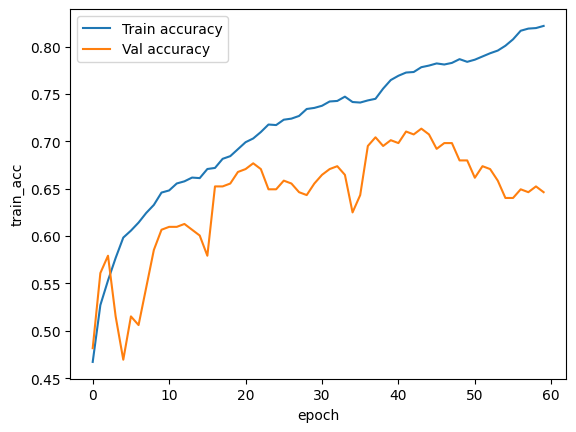

In [16]:
sns.lineplot(data=df_train_val, x='epoch', y='train_acc', label='Train accuracy')
sns.lineplot(data=df_train_val, x='epoch', y='val_acc', label='Val accuracy')
plt.savefig(
    os.path.join(FIGURES_PATH, "pytorch_raw_accuracy_default.png")
)
plt.show()

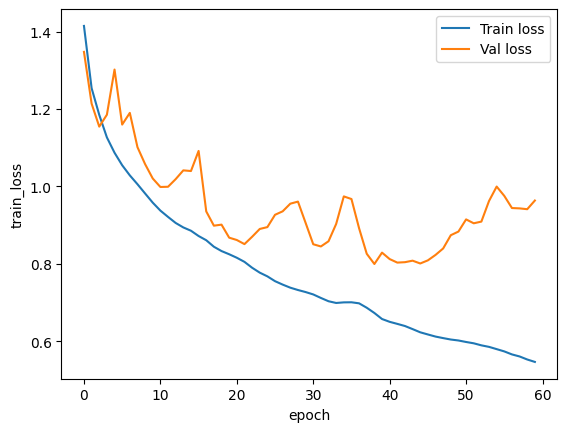

In [17]:
sns.lineplot(data=df_train_val, x='epoch', y='train_loss', label='Train loss')
sns.lineplot(data=df_train_val, x='epoch', y='val_loss', label='Val loss')
plt.savefig(
    os.path.join(FIGURES_PATH, "pytorch_raw_loss_default.png")
)
plt.show()

## Test model

In [18]:
from typing import Dict, List

def test_model(model: nn.Module) -> Dict[str, List[float]]:
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return {
        'labels': all_labels,
        'preds': all_preds
    }

In [19]:
model = GarbageClassificationCNN(num_classes=6)
checkpoint = torch.load(
    os.path.join(PROCESSED_DATA, "best_model_raw.pt"),
    map_location=device
)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

test_data = test_model(model=model)

print("Test accuracy:", (test_data['labels'] == test_data['preds']).mean())

Test accuracy: 0.6751740139211136


In [20]:
print("Classification report:")
print(classification_report(test_data['labels'], test_data['preds'], digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.618     0.671     0.643        82
           1      0.763     0.657     0.706       108
           2      0.981     0.729     0.836        70
           3      0.591     0.743     0.659        74
           4      0.547     0.691     0.610        68
           5      0.667     0.414     0.511        29

    accuracy                          0.675       431
   macro avg      0.694     0.651     0.661       431
weighted avg      0.701     0.675     0.679       431



Confusion matrix:
[[55  5  0 11 11  0]
 [ 3 71  0 17 14  3]
 [ 4  6 51  2  6  1]
 [11  2  1 55  3  2]
 [10  7  0  4 47  0]
 [ 6  2  0  4  5 12]]


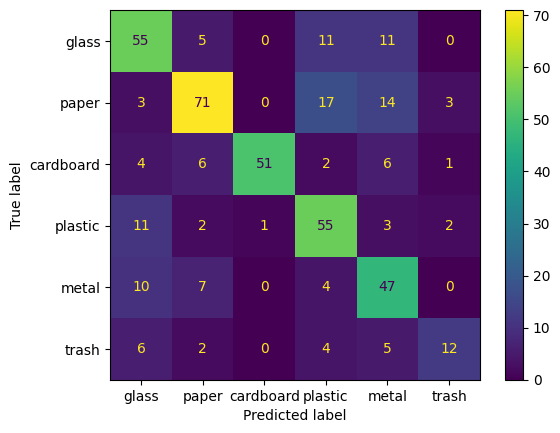

In [21]:
print("Confusion matrix:")
cm = confusion_matrix(test_data['labels'], test_data['preds'])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes.values())
fig = disp.plot()
fig.figure_.savefig(os.path.join(FIGURES_PATH, "pytorch_raw_confusion_matrix_default.png"))
plt.show()

### Observations

* Model almost unable to distinguish trash class

## Tune model

For tuning, let us apply these techniques:

* Add transformations to the images
* Add classes weights (since model is not able to distunguish `trash`)
* Add early stop for training

In [22]:
raw_model = GarbageClassificationCNN(num_classes=6)
raw_model.to(device)

GarbageClassificationCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

### Add transformations

Let us add appropriate transformations (for trainig dataset only)

In [23]:
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

dataset_train = GarbageClassificationDataset(df=df_train, transform=train_transforms)
train_loader = DataLoader(dataset_train, batch_size=32)

### Classes weights

In [24]:
class_counts = df_train["class"].value_counts().sort_index()
print(class_counts)

num_classes = class_counts.shape[0]

alpha = 0.5
class_weights = (1.0 / class_counts) ** alpha
# normalize, so that average weight is ~1
class_weights = class_weights / class_weights.mean()

print("class_weights:\n", class_weights)

# cast to tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(
    raw_model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
)

class
1    354
2    403
3    287
4    347
5    286
6     91
Name: count, dtype: int64
class_weights:
 class
1    0.840011
2    0.787289
3    0.932923
4    0.848441
5    0.934552
6    1.656784
Name: count, dtype: float64


### Add scheduler

In [25]:
def train_eval_model(
    model: nn.Module,
    num_epochs: int,
    best_model_path: str,
    optimizer,
    criterion,
) -> pd.DataFrame:
    rows = []
    best_val_acc = 0.0
    best_model_state = None

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=5,
    )

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for _, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
            }
            torch.save(best_model_state, best_model_path)
            print(f"  >> New best model! Val Acc = {val_acc:.4f}")

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')
        scheduler.step(val_loss)

        rows.append((epoch, train_loss, train_acc, val_loss, val_acc))
        
    return pd.DataFrame(rows, columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

### Train model

In [26]:
df_train_val = train_eval_model(
    model=raw_model,
    num_epochs=60,
    best_model_path=os.path.join(PROCESSED_DATA, "best_model_raw.pt"),
    optimizer=optimizer,
    criterion=criterion
)

  >> New best model! Val Acc = 0.4268
Epoch 1/60
  Train Loss: 1.4680, Train Acc: 0.4333
  Validation Loss: 1.4067, Validation Acc: 0.4268
  >> New best model! Val Acc = 0.5518
Epoch 2/60
  Train Loss: 1.3128, Train Acc: 0.5045
  Validation Loss: 1.2979, Validation Acc: 0.5518
Epoch 3/60
  Train Loss: 1.2522, Train Acc: 0.5283
  Validation Loss: 1.2520, Validation Acc: 0.5213
Epoch 4/60
  Train Loss: 1.2061, Train Acc: 0.5532
  Validation Loss: 1.4683, Validation Acc: 0.4177
Epoch 5/60
  Train Loss: 1.1643, Train Acc: 0.5741
  Validation Loss: 1.2190, Validation Acc: 0.4726
Epoch 6/60
  Train Loss: 1.1376, Train Acc: 0.5826
  Validation Loss: 1.2747, Validation Acc: 0.4909
Epoch 7/60
  Train Loss: 1.1019, Train Acc: 0.5928
  Validation Loss: 1.3800, Validation Acc: 0.4421
Epoch 8/60
  Train Loss: 1.0928, Train Acc: 0.5905
  Validation Loss: 1.2361, Validation Acc: 0.4939
Epoch 9/60
  Train Loss: 1.0731, Train Acc: 0.6007
  Validation Loss: 1.0907, Validation Acc: 0.5518
Epoch 10/60
  T

### Visualize results

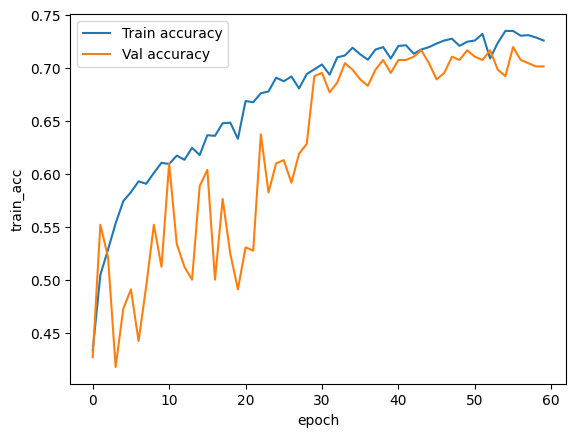

In [27]:
sns.lineplot(data=df_train_val, x='epoch', y='train_acc', label='Train accuracy')
sns.lineplot(data=df_train_val, x='epoch', y='val_acc', label='Val accuracy')
plt.savefig(
    os.path.join(FIGURES_PATH, "pytorch_raw_accuracy_tuned.png")
)
plt.show()

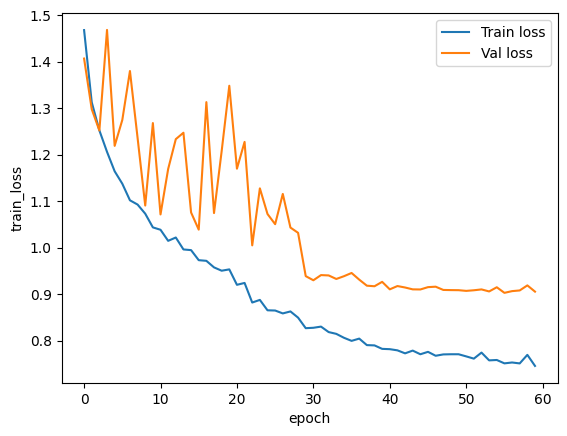

In [28]:
sns.lineplot(data=df_train_val, x='epoch', y='train_loss', label='Train loss')
sns.lineplot(data=df_train_val, x='epoch', y='val_loss', label='Val loss')
plt.savefig(
    os.path.join(FIGURES_PATH, "pytorch_raw_loss_tuned.png")
)
plt.show()

### Test model

In [29]:
model = GarbageClassificationCNN(num_classes=6)
checkpoint = torch.load(
    os.path.join(PROCESSED_DATA, "best_model_raw.pt"),
    map_location=device
)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

test_data = test_model(model=model)

print("Test accuracy:", (test_data['labels'] == test_data['preds']).mean())

Test accuracy: 0.7308584686774942


In [30]:
print("Classification report:")
print(classification_report(test_data['labels'], test_data['preds'], digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.677     0.768     0.720        82
           1      0.806     0.769     0.787       108
           2      0.935     0.829     0.879        70
           3      0.746     0.635     0.686        74
           4      0.643     0.662     0.652        68
           5      0.475     0.655     0.551        29

    accuracy                          0.731       431
   macro avg      0.714     0.720     0.712       431
weighted avg      0.744     0.731     0.735       431



Confusion matrix:
[[63  2  0  5 11  1]
 [ 2 83  0  5  8 10]
 [ 2  3 58  2  3  2]
 [ 9  9  3 47  3  3]
 [11  4  0  3 45  5]
 [ 6  2  1  1  0 19]]


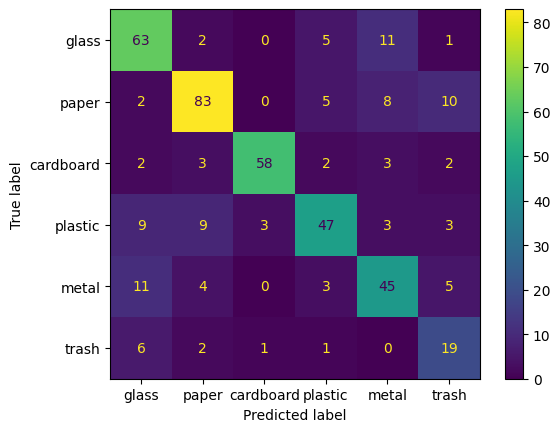

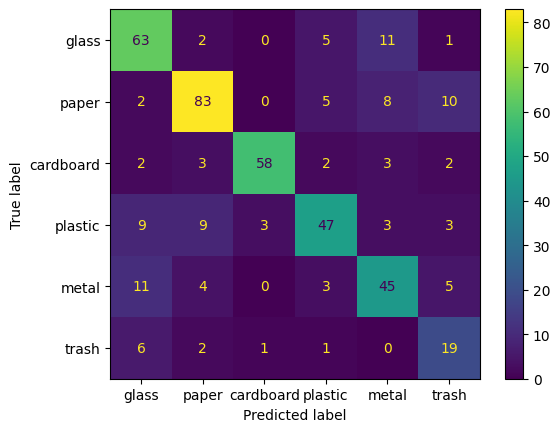

In [31]:
print("Confusion matrix:")
cm = confusion_matrix(test_data['labels'], test_data['preds'])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes.values())
fig = disp.plot()
fig.figure_.savefig(os.path.join(FIGURES_PATH, "pytorch_raw_confusion_matrix_tuned.png"))
fig.plot()

### Observations

* After tuning accuracy has increased